In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns

from collections.abc import Iterable

import scipy.sparse as sp
from sklearn import model_selection

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

from stellargraph import StellarGraph
from stellargraph.layer import GCN
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
from stellargraph.layer import GCNSupervisedGraphClassification

from tensorflow.keras import layers, models
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


Bad key "text.kerning_factor" on line 4 in
C:\Users\Bombshell\AppData\Local\Programs\Python\Python36\Scripts\gcntest6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\Bombshell\AppData\Local\Programs\Python\Python36\Scripts\gcntest6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
os.chdir(r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\train")
train_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\train"
val_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\malimg_dataset\validation"

val_datagen = ImageDataGenerator()
batch_size = 30000
img_size = (32, 32)
color_mode= "grayscale"

val_generator = val_datagen.flow_from_directory(val_root, 
                                                target_size=img_size, 
                                                batch_size=batch_size,
                                                color_mode=color_mode)

val_steps_per_epoch = val_generator.samples // batch_size
X_val, y_val = next(val_generator)

for i in range(val_steps_per_epoch - 1):
    batch_x, batch_y = next(val_generator)
    X_val = np.concatenate([X_val, batch_x])
    y_val = np.concatenate([y_val, batch_y])
y_val_labels = np.argmax(y_val, axis=1)
    
batches = ImageDataGenerator().flow_from_directory(directory=train_root, 
                                                   target_size=(32,32), 
                                                   batch_size=100000,
                                                   color_mode=color_mode)
imgs, labels = next(batches)
rescaled_imgs = imgs.astype(float) / 255.0
rescaled_X_val = X_val.astype(float) / 255.0

Found 935 images belonging to 25 classes.
Found 8404 images belonging to 25 classes.


In [3]:
#Add node attribute that stores the mean edge weight incident to a node
categorical_labels = np.argmax(labels, axis=1)

def create_graphs(image_data):
    graphs = []
    graphs_stored = 0
    
    for img in tqdm(image_data, 
                    desc=f'Samples stored in memory {graphs_stored + 1}/{8404}', 
                    leave=False):
        height, width, channels = img.shape
        pixel_values = img.reshape((height * width))
        
        # Create the nodes dictionary
        nodes = {i: {"pixel_value": pixel_values[i]} for i in range(height * width)}
        nodes_df = pd.DataFrame.from_dict(nodes, orient="index")
        nodes_df["x"] = nodes_df.index // width
        nodes_df["y"] = nodes_df.index % width
        
        # Create edges
        edges = []
        edge_weights = []
        for i in range(height):
            for j in range(width):
                node_id = i * width + j
                
                if i > 0: # Check for upward edge
                    neighbor_id = node_id - width
                    edges.append((node_id, neighbor_id))
                    edge_weights.append(abs(nodes_df.loc[node_id, "pixel_value"] - nodes_df.loc[neighbor_id, "pixel_value"]))
                if j > 0: # Check for leftward edge
                    neighbor_id = node_id - 1
                    edges.append((node_id, neighbor_id))
                    edge_weights.append(abs(nodes_df.loc[node_id, "pixel_value"] - nodes_df.loc[neighbor_id, "pixel_value"]))

                if i < height - 1:  # Check for downward edge
                    neighbor_id = node_id + width
                    edges.append((node_id, neighbor_id))
                    edge_weights.append(abs(nodes_df.loc[node_id, "pixel_value"] - nodes_df.loc[neighbor_id, "pixel_value"]))
        
                if j < width - 1:  # Check for rightward edge
                    neighbor_id = node_id + 1
                    edges.append((node_id, neighbor_id))
                    edge_weights.append(abs(nodes_df.loc[node_id, "pixel_value"] - nodes_df.loc[neighbor_id, "pixel_value"]))
       
        # Create the StellarGraph object
        edges_df = pd.DataFrame(edges, columns=["source", "target"])
        edges_df["weight"] = edge_weights
        
        mean_edge_weights = edges_df.groupby('target')['weight'].mean()
        nodes_df['mean_neighbors'] = mean_edge_weights.reindex(nodes_df.index, fill_value=0)
        
        stddev_edge_weights = edges_df.groupby('target')['weight'].std()
        nodes_df['stddev_neighbors'] = stddev_edge_weights.reindex(nodes_df.index, fill_value=0)

        G = StellarGraph(nodes_df, edges_df)
        graphs.append(G)
        graphs_stored += 1
          
    return graphs, nodes_df, edges_df

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(rescaled_imgs, 
                                                                    categorical_labels, 
                                                                    test_size=0.2, 
                                                                    random_state=429)

train_graphs, nodes_df_train, edges_df_train = create_graphs(X_train)
val_graphs, nodes_df_val, edges_df_val = create_graphs(rescaled_X_val)

train_generator = PaddedGraphGenerator(graphs=train_graphs)
val_generator = PaddedGraphGenerator(graphs=val_graphs)

In [8]:
param_grid = {
    'layer_sizes': [(32, 32), (64, 64), (128, 128)],
    'dense_units': [64, 128, 256, 512, 1024],
}

def train_fold(model, train_gen, val_gen, es, epochs):
    
    history = model.fit(train_gen, epochs=epochs, 
                        validation_data=val_gen, verbose=2, callbacks=[es],
    )
    
    test_metrics = model.evaluate(val_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

def create_graph_classification_model(generator, layer_sizes, dense_units):
    gc_model = GCNSupervisedGraphClassification(layer_sizes=layer_sizes,
                                                activations=["relu"] * len(layer_sizes),
                                                generator=generator)
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = x_out
    
    for units in dense_units:
        predictions = Dense(units=units, activation="relu")(predictions)
    
    predictions = Dense(units=25, activation="softmax")(predictions)
    
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.001), 
                  loss=sparse_categorical_crossentropy, metrics=["acc"])
    return model

epochs = 50
folds = 10
n_repeats = 1
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=40, restore_best_weights=True)

#Keeping track of best setup
best_accuracy = 0.0
best_params = None

# Loop over parameter combinations
for layer_sizes in param_grid['layer_sizes']:
    for dense_units in param_grid['dense_units']:
        print("Current combination: layer_sizes={}, dense_units={}".format(layer_sizes, dense_units))
        # Create the model
        model = create_graph_classification_model(train_generator, layer_sizes, [dense_units])
        
        # Train the model
        history, acc = train_fold(model, 
                                  train_generator.flow(np.arange(len(X_train)), y_train, batch_size=30), 
                                  val_generator.flow(np.arange(len(rescaled_X_val)), y_val_labels, batch_size=30), 
                                  es, 
                                  epochs)
        
        # Check if this is the best model so far
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {'layer_sizes': layer_sizes, 'dense_units': dense_units}

# Print the best parameters and best accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Current combination: layer_sizes=(32, 32), dense_units=64
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 32 steps
Epoch 1/50
225/225 - 56s - loss: 2.4834 - acc: 0.3305 - val_loss: 3.3077 - val_acc: 0.1337
Epoch 2/50
225/225 - 53s - loss: 2.4514 - acc: 0.3304 - val_loss: 3.3403 - val_acc: 0.1337
Epoch 3/50
225/225 - 53s - loss: 2.4439 - acc: 0.3335 - val_loss: 3.3537 - val_acc: 0.1337
Epoch 4/50
225/225 - 53s - loss: 2.4342 - acc: 0.3335 - val_loss: 3.2925 - val_acc: 0.1337
Epoch 5/50
225/225 - 52s - loss: 2.4257 - acc: 0.3335 - val_loss: 3.2102 - val_acc: 0.1337
Epoch 6/50
225/225 - 53s - loss: 2.4068 - acc: 0.3335 - val_loss: 3.1306 - val_acc: 0.1337
Epoch 7/50
225/225 - 53s - loss: 2.3378 - acc: 0.3399 - val_loss: 3.0805 - val_acc: 0.1615
Epoch 8/50
225/225 - 53s - loss: 2.1805 - acc: 0.3641 - val_loss: 2.8115 - val_acc: 0.1818
Epoch 9/50
225/225 - 53s - loss: 2.0418 - acc: 0.3821 - val_loss: 2.7141 - val_acc: 0.2096
Epoch 10/50
225/225 - 53s - lo

Epoch 34/50
225/225 - 54s - loss: 1.0667 - acc: 0.6287 - val_loss: 1.4006 - val_acc: 0.5123
Epoch 35/50
225/225 - 54s - loss: 1.0298 - acc: 0.6369 - val_loss: 1.3216 - val_acc: 0.5380
Epoch 36/50
225/225 - 54s - loss: 1.0348 - acc: 0.6308 - val_loss: 1.4537 - val_acc: 0.4567
Epoch 37/50
225/225 - 54s - loss: 1.0190 - acc: 0.6487 - val_loss: 1.2511 - val_acc: 0.5444
Epoch 38/50
225/225 - 54s - loss: 0.9965 - acc: 0.6464 - val_loss: 1.2535 - val_acc: 0.5455
Epoch 39/50
225/225 - 54s - loss: 0.9982 - acc: 0.6447 - val_loss: 1.2420 - val_acc: 0.5283
Epoch 40/50
225/225 - 54s - loss: 0.9905 - acc: 0.6518 - val_loss: 1.3285 - val_acc: 0.5412
Epoch 41/50
225/225 - 54s - loss: 0.9739 - acc: 0.6567 - val_loss: 1.1873 - val_acc: 0.5316
Epoch 42/50
225/225 - 54s - loss: 0.9606 - acc: 0.6585 - val_loss: 1.2570 - val_acc: 0.5401
Epoch 43/50
225/225 - 54s - loss: 0.9619 - acc: 0.6597 - val_loss: 1.3645 - val_acc: 0.5241
Epoch 44/50
225/225 - 54s - loss: 0.9354 - acc: 0.6579 - val_loss: 1.1811 - val_

Epoch 16/50
225/225 - 55s - loss: 1.0869 - acc: 0.6268 - val_loss: 1.3140 - val_acc: 0.5273
Epoch 17/50
225/225 - 55s - loss: 1.0462 - acc: 0.6377 - val_loss: 1.3776 - val_acc: 0.4920
Epoch 18/50
225/225 - 55s - loss: 1.0306 - acc: 0.6372 - val_loss: 1.3503 - val_acc: 0.4930
Epoch 19/50
225/225 - 55s - loss: 1.0035 - acc: 0.6490 - val_loss: 1.3343 - val_acc: 0.5091
Epoch 20/50
225/225 - 55s - loss: 0.9901 - acc: 0.6551 - val_loss: 1.3500 - val_acc: 0.5251
Epoch 21/50
225/225 - 55s - loss: 1.0053 - acc: 0.6452 - val_loss: 1.2625 - val_acc: 0.5262
Epoch 22/50
225/225 - 55s - loss: 0.9544 - acc: 0.6595 - val_loss: 1.2711 - val_acc: 0.5380
Epoch 23/50
225/225 - 55s - loss: 0.9224 - acc: 0.6740 - val_loss: 1.2066 - val_acc: 0.5487
Epoch 24/50
225/225 - 55s - loss: 0.9255 - acc: 0.6786 - val_loss: 1.2093 - val_acc: 0.5369
Epoch 25/50
225/225 - 55s - loss: 0.9018 - acc: 0.6801 - val_loss: 1.0851 - val_acc: 0.6481
Epoch 26/50
225/225 - 55s - loss: 0.8930 - acc: 0.6762 - val_loss: 1.0809 - val_

Current combination: layer_sizes=(64, 64), dense_units=64
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 32 steps
Epoch 1/50
225/225 - 63s - loss: 2.5510 - acc: 0.3220 - val_loss: 3.3221 - val_acc: 0.1337
Epoch 2/50
225/225 - 63s - loss: 2.4462 - acc: 0.3330 - val_loss: 3.2707 - val_acc: 0.1337
Epoch 3/50
225/225 - 62s - loss: 2.4348 - acc: 0.3287 - val_loss: 3.2884 - val_acc: 0.1326
Epoch 4/50
225/225 - 63s - loss: 2.3594 - acc: 0.3345 - val_loss: 3.0940 - val_acc: 0.1636
Epoch 5/50
225/225 - 61s - loss: 2.1508 - acc: 0.3696 - val_loss: 2.8184 - val_acc: 0.1872
Epoch 6/50
225/225 - 61s - loss: 1.9475 - acc: 0.3861 - val_loss: 2.4623 - val_acc: 0.1872
Epoch 7/50
225/225 - 61s - loss: 1.8272 - acc: 0.4126 - val_loss: 2.3531 - val_acc: 0.2096
Epoch 8/50
225/225 - 61s - loss: 1.7389 - acc: 0.4364 - val_loss: 2.2972 - val_acc: 0.2107
Epoch 9/50
225/225 - 62s - loss: 1.6717 - acc: 0.4589 - val_loss: 2.2352 - val_acc: 0.2620
Epoch 10/50
225/225 - 62s - lo

Epoch 34/50
225/225 - 62s - loss: 0.8404 - acc: 0.6966 - val_loss: 1.0659 - val_acc: 0.6460
Epoch 35/50
225/225 - 62s - loss: 0.8261 - acc: 0.6966 - val_loss: 1.0293 - val_acc: 0.5957
Epoch 36/50
225/225 - 62s - loss: 0.7976 - acc: 0.7122 - val_loss: 1.0043 - val_acc: 0.6642
Epoch 37/50
225/225 - 62s - loss: 0.7971 - acc: 0.7089 - val_loss: 1.0559 - val_acc: 0.6086
Epoch 38/50
225/225 - 62s - loss: 0.7892 - acc: 0.7098 - val_loss: 1.1612 - val_acc: 0.6225
Epoch 39/50
225/225 - 62s - loss: 0.7778 - acc: 0.7135 - val_loss: 0.9350 - val_acc: 0.6674
Epoch 40/50
225/225 - 62s - loss: 0.7723 - acc: 0.7155 - val_loss: 0.9662 - val_acc: 0.6299
Epoch 41/50
225/225 - 62s - loss: 0.7499 - acc: 0.7202 - val_loss: 0.9172 - val_acc: 0.6802
Epoch 42/50
225/225 - 62s - loss: 0.7325 - acc: 0.7303 - val_loss: 0.8769 - val_acc: 0.7112
Epoch 43/50
225/225 - 62s - loss: 0.7479 - acc: 0.7250 - val_loss: 0.9196 - val_acc: 0.6770
Epoch 44/50
225/225 - 62s - loss: 0.7262 - acc: 0.7339 - val_loss: 1.1421 - val_

Epoch 16/50
225/225 - 61s - loss: 1.0231 - acc: 0.6490 - val_loss: 1.2990 - val_acc: 0.5390
Epoch 17/50
225/225 - 61s - loss: 0.9905 - acc: 0.6629 - val_loss: 1.4209 - val_acc: 0.5305
Epoch 18/50
225/225 - 61s - loss: 0.9781 - acc: 0.6613 - val_loss: 1.1924 - val_acc: 0.6128
Epoch 19/50
225/225 - 61s - loss: 0.9217 - acc: 0.6815 - val_loss: 1.2698 - val_acc: 0.5733
Epoch 20/50
225/225 - 60s - loss: 0.8944 - acc: 0.6862 - val_loss: 1.1143 - val_acc: 0.5914
Epoch 21/50
225/225 - 62s - loss: 0.8611 - acc: 0.6954 - val_loss: 1.1260 - val_acc: 0.6011
Epoch 22/50
225/225 - 61s - loss: 0.8789 - acc: 0.6911 - val_loss: 1.2058 - val_acc: 0.6235
Epoch 23/50
225/225 - 61s - loss: 0.8018 - acc: 0.7177 - val_loss: 1.0629 - val_acc: 0.6353
Epoch 24/50
225/225 - 61s - loss: 0.7942 - acc: 0.7274 - val_loss: 0.9865 - val_acc: 0.6866
Epoch 25/50
225/225 - 62s - loss: 0.7550 - acc: 0.7346 - val_loss: 1.0521 - val_acc: 0.6610
Epoch 26/50
225/225 - 61s - loss: 0.7435 - acc: 0.7361 - val_loss: 1.0046 - val_

Current combination: layer_sizes=(128, 128), dense_units=64
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 32 steps
Epoch 1/50
225/225 - 70s - loss: 2.4916 - acc: 0.3257 - val_loss: 3.4537 - val_acc: 0.1337
Epoch 2/50
225/225 - 70s - loss: 2.4524 - acc: 0.3335 - val_loss: 3.2762 - val_acc: 0.1337
Epoch 3/50
225/225 - 69s - loss: 2.4193 - acc: 0.3335 - val_loss: 3.2666 - val_acc: 0.1337
Epoch 4/50
225/225 - 69s - loss: 2.2683 - acc: 0.3482 - val_loss: 2.8587 - val_acc: 0.1765
Epoch 5/50
225/225 - 69s - loss: 2.0237 - acc: 0.3887 - val_loss: 2.7213 - val_acc: 0.1840
Epoch 6/50
225/225 - 69s - loss: 1.8616 - acc: 0.4128 - val_loss: 2.3993 - val_acc: 0.2278
Epoch 7/50
225/225 - 69s - loss: 1.7459 - acc: 0.4397 - val_loss: 2.3821 - val_acc: 0.2075
Epoch 8/50
225/225 - 69s - loss: 1.7074 - acc: 0.4611 - val_loss: 2.3772 - val_acc: 0.2064
Epoch 9/50
225/225 - 69s - loss: 1.6236 - acc: 0.4833 - val_loss: 2.2384 - val_acc: 0.2385
Epoch 10/50
225/225 - 69s - 

Epoch 34/50
225/225 - 58s - loss: 0.6508 - acc: 0.7538 - val_loss: 0.7715 - val_acc: 0.7444
Epoch 35/50
225/225 - 58s - loss: 0.6334 - acc: 0.7633 - val_loss: 0.8063 - val_acc: 0.7262
Epoch 36/50
225/225 - 58s - loss: 0.6213 - acc: 0.7720 - val_loss: 0.8095 - val_acc: 0.7187
Epoch 37/50
225/225 - 58s - loss: 0.6224 - acc: 0.7677 - val_loss: 0.7459 - val_acc: 0.7358
Epoch 38/50
225/225 - 57s - loss: 0.6162 - acc: 0.7672 - val_loss: 0.6988 - val_acc: 0.7444
Epoch 39/50
225/225 - 58s - loss: 0.6144 - acc: 0.7656 - val_loss: 0.8148 - val_acc: 0.7166
Epoch 40/50
225/225 - 58s - loss: 0.6164 - acc: 0.7683 - val_loss: 0.7484 - val_acc: 0.7348
Epoch 41/50
225/225 - 58s - loss: 0.5959 - acc: 0.7706 - val_loss: 0.7618 - val_acc: 0.7305
Epoch 42/50
225/225 - 58s - loss: 0.6129 - acc: 0.7653 - val_loss: 0.7657 - val_acc: 0.7155
Epoch 43/50
225/225 - 58s - loss: 0.5808 - acc: 0.7739 - val_loss: 0.7068 - val_acc: 0.7444
Epoch 44/50
225/225 - 58s - loss: 0.5867 - acc: 0.7730 - val_loss: 0.7058 - val_

Epoch 16/50
225/225 - 67s - loss: 0.7723 - acc: 0.7340 - val_loss: 0.9618 - val_acc: 0.6930
Epoch 17/50
225/225 - 67s - loss: 0.7274 - acc: 0.7495 - val_loss: 0.8154 - val_acc: 0.7380
Epoch 18/50
225/225 - 67s - loss: 0.7198 - acc: 0.7412 - val_loss: 0.8502 - val_acc: 0.6749
Epoch 19/50
225/225 - 67s - loss: 0.6997 - acc: 0.7537 - val_loss: 0.7918 - val_acc: 0.7273
Epoch 20/50
225/225 - 67s - loss: 0.6753 - acc: 0.7552 - val_loss: 0.7732 - val_acc: 0.7219
Epoch 21/50
225/225 - 67s - loss: 0.6571 - acc: 0.7599 - val_loss: 1.0096 - val_acc: 0.6053
Epoch 22/50
225/225 - 67s - loss: 0.6578 - acc: 0.7552 - val_loss: 0.8765 - val_acc: 0.7037
Epoch 23/50
225/225 - 67s - loss: 0.6386 - acc: 0.7626 - val_loss: 0.7860 - val_acc: 0.7155
Epoch 24/50
225/225 - 67s - loss: 0.6364 - acc: 0.7611 - val_loss: 0.7261 - val_acc: 0.7241
Epoch 25/50
225/225 - 67s - loss: 0.6235 - acc: 0.7616 - val_loss: 0.7259 - val_acc: 0.7123
Epoch 26/50
225/225 - 67s - loss: 0.6347 - acc: 0.7599 - val_loss: 0.9552 - val_

Best Parameters:  {'layer_sizes': (64, 64), 'dense_units': 512}
Best Accuracy:  0.75080216


In [9]:
def train_fold(model, train_gen, val_gen, es, epochs):
    
    history = model.fit(train_gen, epochs=epochs, 
                        validation_data=val_gen, verbose=2, callbacks=[es],
    )
    
    # Calculate performance on the test data and return along with history
    test_metrics = model.evaluate(val_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [11]:
model = create_graph_classification_model(train_generator, layer_sizes, [dense_units])
history, acc = train_fold(model, 
                          train_generator.flow(np.arange(len(X_train)), y_train, batch_size=30), 
                          val_generator.flow(np.arange(len(rescaled_X_val)), y_val_labels, batch_size=30), 
                          es, 
                          epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 32 steps
Epoch 1/50
225/225 - 70s - loss: 2.4775 - acc: 0.3299 - val_loss: 3.2279 - val_acc: 0.1337
Epoch 2/50
225/225 - 69s - loss: 2.4390 - acc: 0.3335 - val_loss: 3.1781 - val_acc: 0.1337
Epoch 3/50
225/225 - 69s - loss: 2.1949 - acc: 0.3594 - val_loss: 2.6630 - val_acc: 0.1989
Epoch 4/50
225/225 - 69s - loss: 1.7610 - acc: 0.4378 - val_loss: 2.2114 - val_acc: 0.2802
Epoch 5/50
225/225 - 66s - loss: 1.4806 - acc: 0.5169 - val_loss: 1.8454 - val_acc: 0.3690
Epoch 6/50
225/225 - 66s - loss: 1.3113 - acc: 0.5694 - val_loss: 1.7983 - val_acc: 0.3615
Epoch 7/50
225/225 - 66s - loss: 1.2491 - acc: 0.5820 - val_loss: 1.5763 - val_acc: 0.4428
Epoch 8/50
225/225 - 66s - loss: 1.1850 - acc: 0.6003 - val_loss: 1.4968 - val_acc: 0.4246
Epoch 9/50
225/225 - 66s - loss: 1.1117 - acc: 0.6185 - val_loss: 1.3193 - val_acc: 0.5112
Epoch 10/50
225/225 - 66s - loss: 1.0255 - acc: 0.6445 - val_loss: 1.1881 - val_acc: 0.5

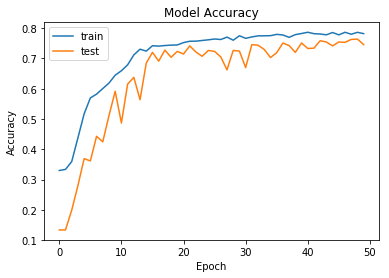

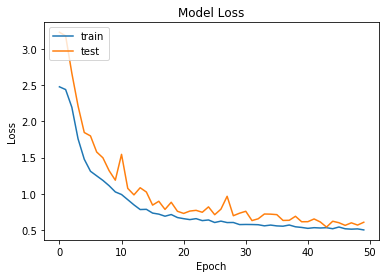

In [36]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

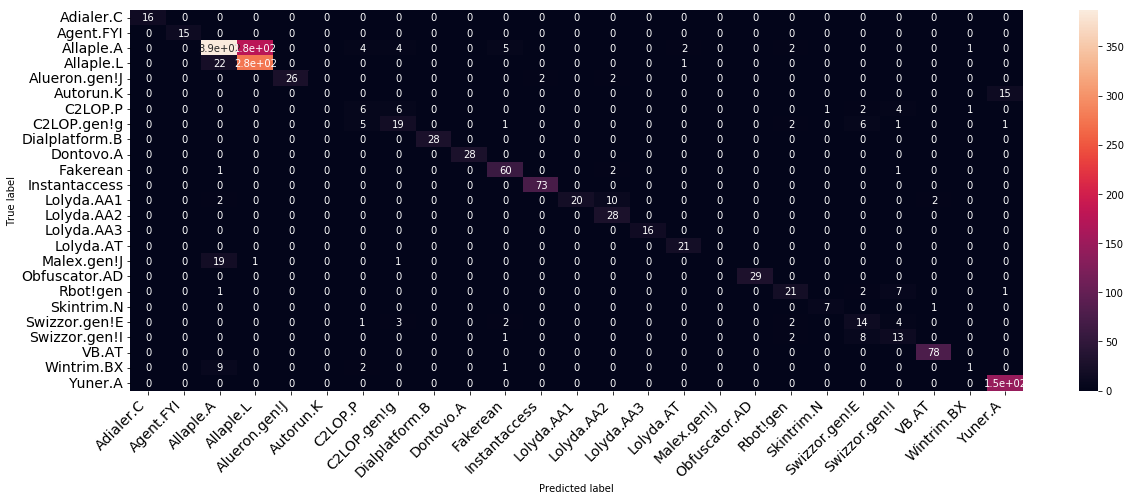

In [13]:
test_graphs, nodes_df_test, edges_df_test = create_graphs(X_test)
test_generator = PaddedGraphGenerator(graphs=test_graphs)

predict_x=model.predict(test_generator.flow(np.arange(len(X_test)), y_test, batch_size=30))
classes_x=np.argmax(predict_x,axis=1)

c_matrix = metrics.confusion_matrix(y_test, classes_x)
c_matrix_normalized = c_matrix.astype('int32') / c_matrix.sum(axis=1)[:, np.newaxis]

def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def percent_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True)  
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [17]:
correct_predictions = np.diagonal(c_matrix)
total_samples = np.sum(c_matrix)
accuracy = np.sum(correct_predictions) / total_samples
precision, recall, f1, support = precision_recall_fscore_support(y_test, classes_x, average="macro")

print("-" * 40)
print("Accuracy:     ", accuracy)
print("Avg Precision:", (precision))
print("Avg Recall:   ", (recall))
print("Avg F1 score: ", (f1))
print("-" * 40)

----------------------------------------
Accuracy:      0.7900059488399762
Avg Precision: 0.7371474953678775
Avg Recall:    0.7404634304951163
Avg F1 score:  0.7291125574567013
----------------------------------------


C:\Users\Bombshell\AppData\Local\Programs\Python\Python36\Scripts\gcntest6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
total_samples = np.sum(c_matrix, axis=1)  # sum along the rows
class_accuracy = correct_predictions / total_samples
num_samples = np.sum(c_matrix, axis=1)  # sum along the rows
print("Class statistics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {num_samples[i]} test samples, {correct_predictions[i]} predictions correct")
    print(f"Accuracy: {class_accuracy[i]:.2%}\n")

Class statistics:
Adialer.C: 16 test samples, 16 predictions correct
Accuracy: 100.00%

Agent.FYI: 15 test samples, 15 predictions correct
Accuracy: 100.00%

Allaple.A: 582 test samples, 387 predictions correct
Accuracy: 66.49%

Allaple.L: 299 test samples, 276 predictions correct
Accuracy: 92.31%

Alueron.gen!J: 30 test samples, 26 predictions correct
Accuracy: 86.67%

Autorun.K: 15 test samples, 0 predictions correct
Accuracy: 0.00%

C2LOP.P: 20 test samples, 6 predictions correct
Accuracy: 30.00%

C2LOP.gen!g: 35 test samples, 19 predictions correct
Accuracy: 54.29%

Dialplatform.B: 28 test samples, 28 predictions correct
Accuracy: 100.00%

Dontovo.A: 28 test samples, 28 predictions correct
Accuracy: 100.00%

Fakerean: 64 test samples, 60 predictions correct
Accuracy: 93.75%

Instantaccess: 73 test samples, 73 predictions correct
Accuracy: 100.00%

Lolyda.AA1: 34 test samples, 20 predictions correct
Accuracy: 58.82%

Lolyda.AA2: 28 test samples, 28 predictions correct
Accuracy: 100.

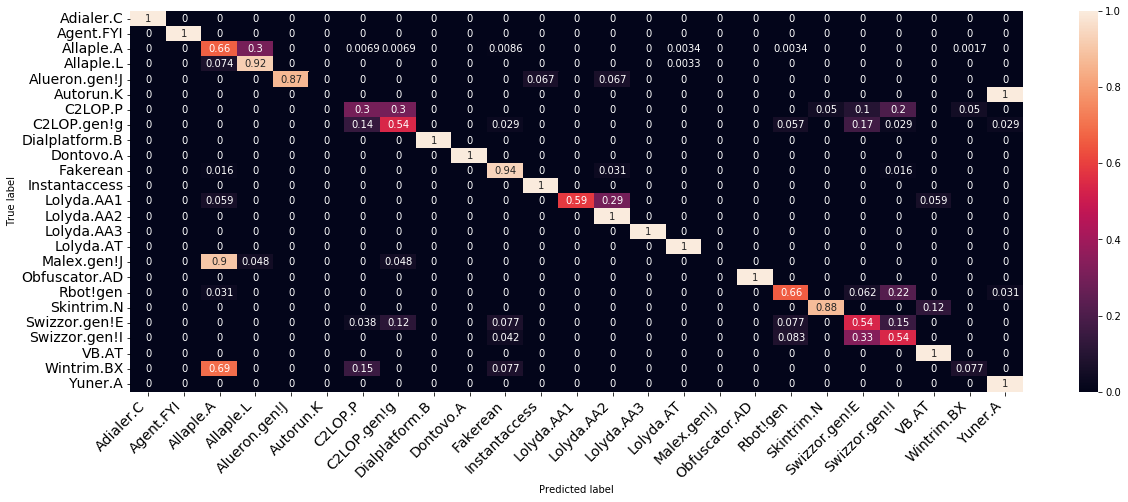

In [19]:
percent_confusion_matrix(c_matrix_normalized, class_names, figsize = (20,7), fontsize=14)

In [29]:
#Verifying the structure of nodes and edges matches training examples

os.chdir(r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\GraphViewTester\train")
train_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\GraphViewTester\train"
val_root = r"E:\MalwareAnal\malimgdataset\archive\dataset_9010\dataset_9010\GraphViewTester\validation"

batches = ImageDataGenerator().flow_from_directory(directory=train_root, 
                                                   target_size=(32,32), 
                                                   batch_size=100000,
                                                   color_mode=color_mode)
imgs2, labels2 = next(batches)
rescaled_imgs2 = imgs2.astype(float) / 255.0

X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(
    rescaled_imgs2, labels2, test_size=0, random_state=420)

train_graphs2, nodes_df_train2, edges_df_train2 = create_graphs(X_train2)

Found 1 images belonging to 1 classes.


Image shape: (32, 32, 1)


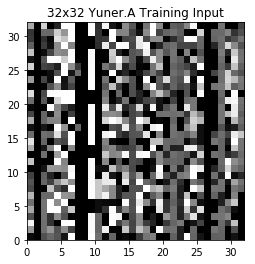

In [30]:
img_idx = 0
clipped_imgs = imgs2 / 255.
img2 = clipped_imgs[img_idx]

print("Image shape:", img2.shape)

fig, ax = plt.subplots()
img2 = img2.squeeze()

# Plot the image with specified extent
img2_rotated = np.rot90(img2, k=1)
ax.imshow(img2_rotated, extent=[0, img2_rotated.shape[1], 0, img2_rotated.shape[0]], cmap="gray")

# Move the left spine of the plot to the y-axis zero position
ax.spines['left'].set_position('zero')
plt.title('32x32 Yuner.A Training Input')
plt.show()

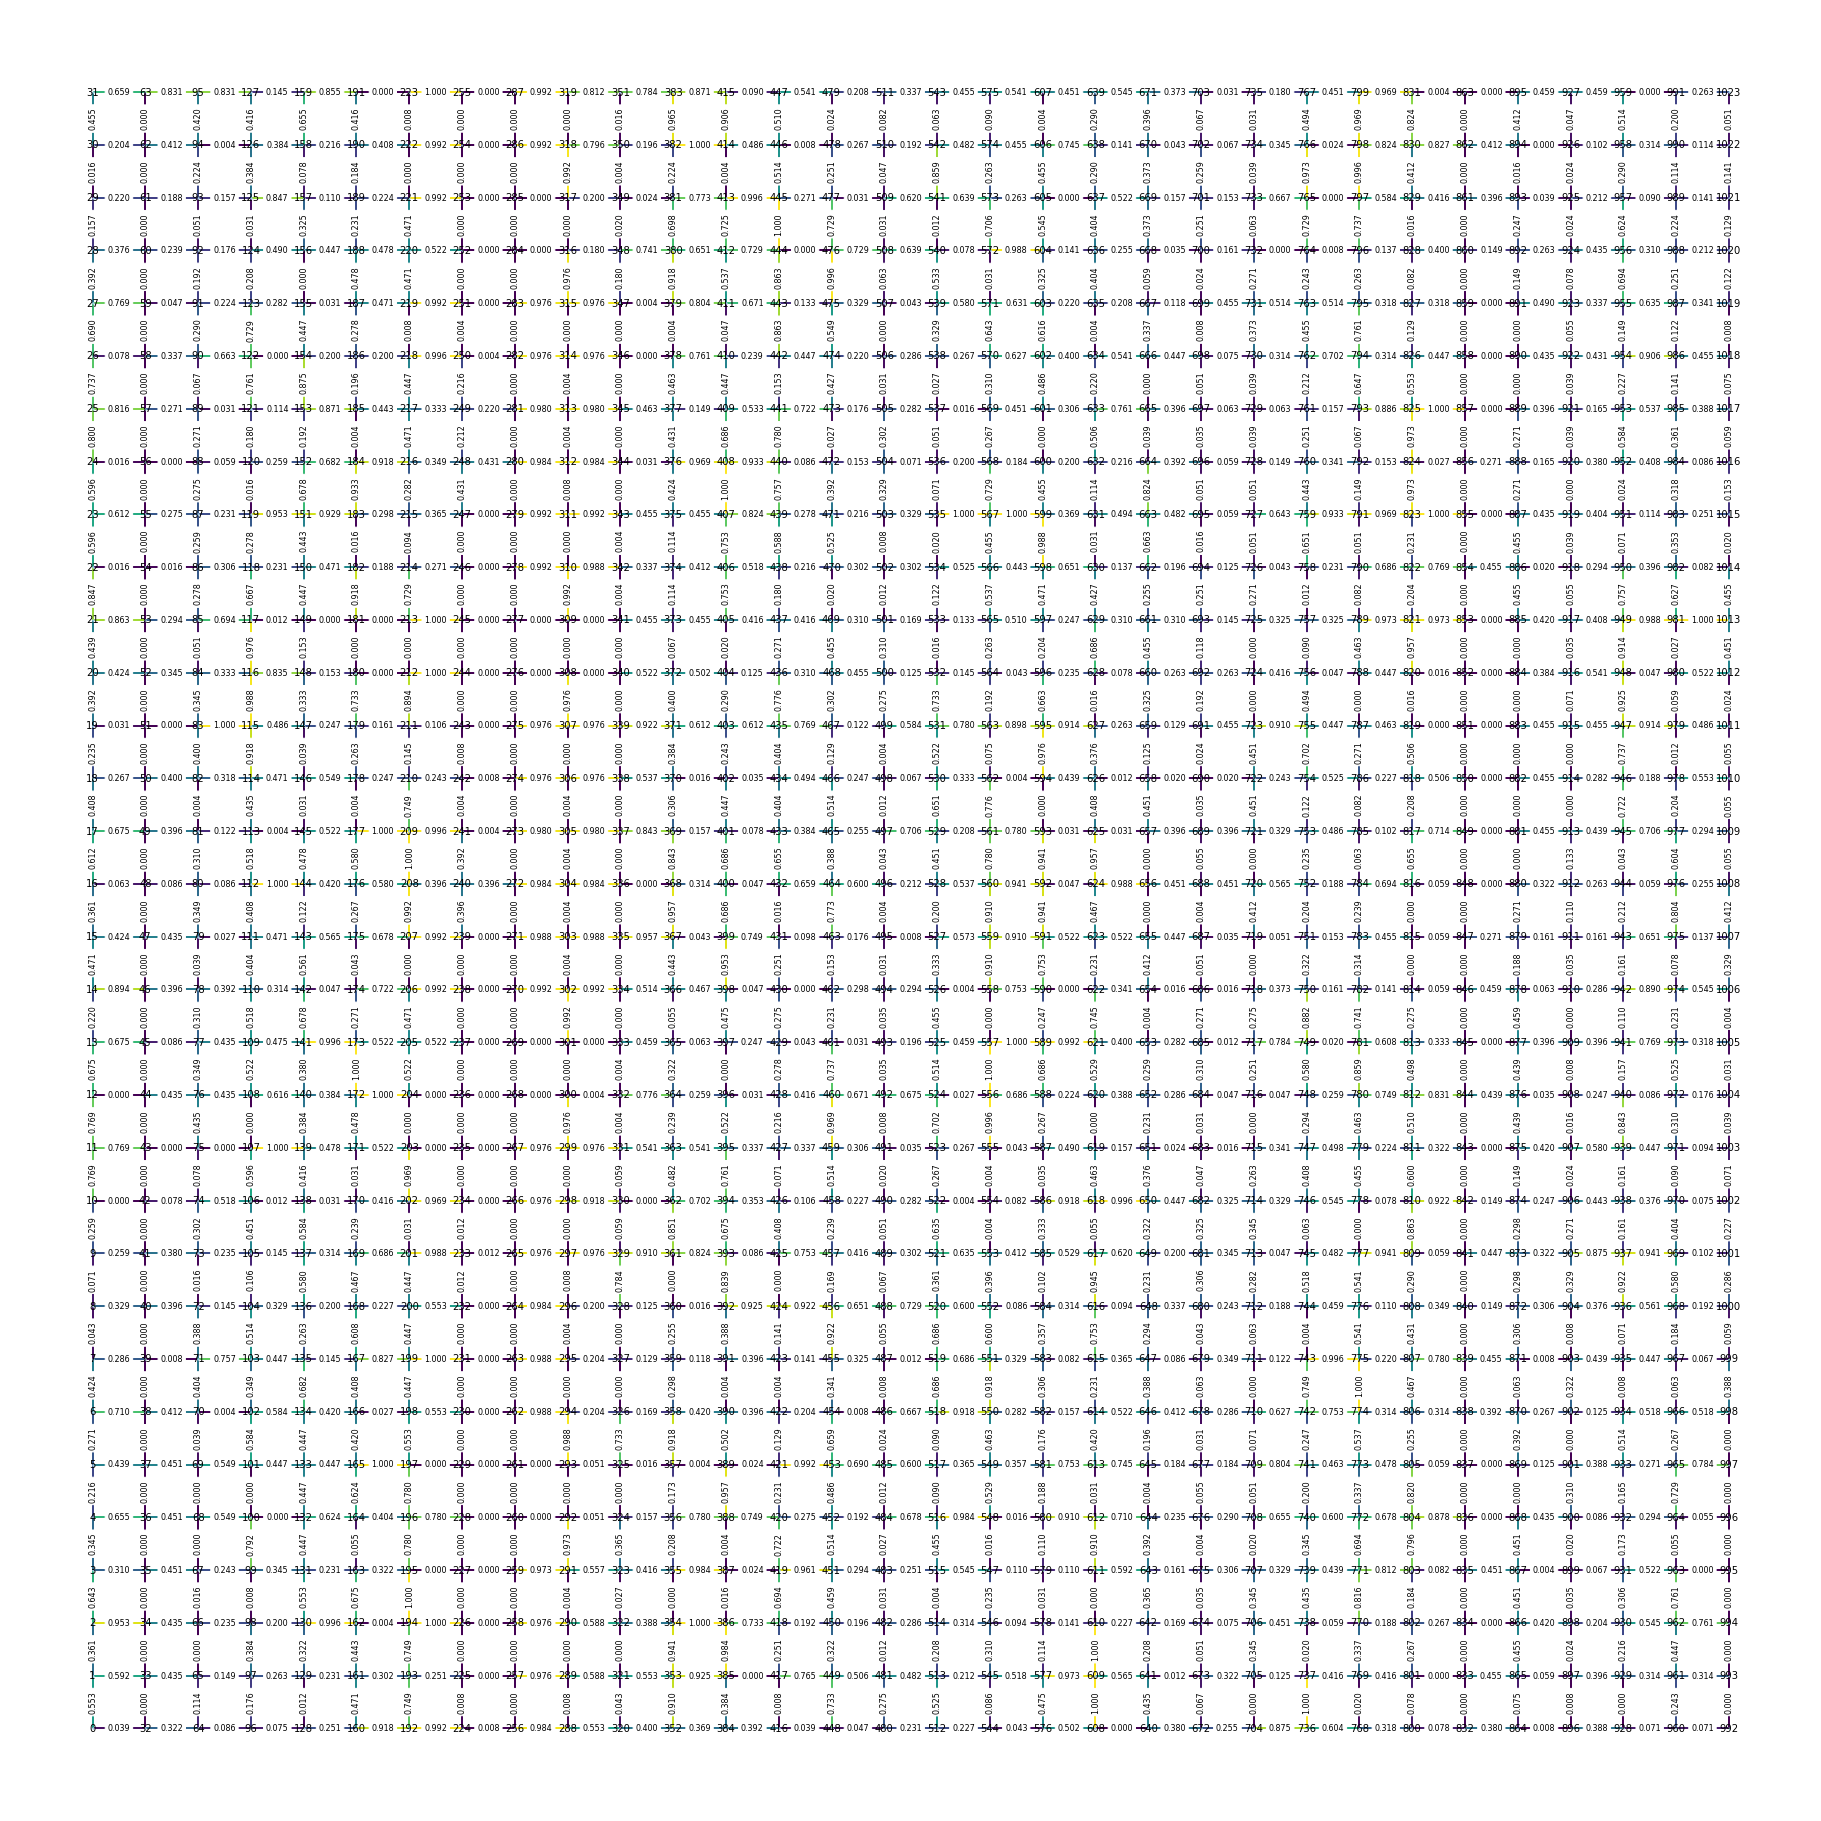

In [32]:
#Plotting node and edge values to check correctness with training sample

graph_to_plot = train_graphs2[0]
nx_graph = graph_to_plot.to_networkx()

# Get node positions based on x and y attributes
node_positions = {node: (nodes_df_train.loc[node, 'x'], 
                         nodes_df_train.loc[node, 'y']) for node in nx_graph.nodes()}

edges = nx_graph.edges()
edge_weights = [data['weight'] for _, _, data in nx_graph.edges(data=True)]
edge_weights_array = np.array(edge_weights)

normalized_weights = (edge_weights_array - edge_weights_array.min()) / \
               (edge_weights_array.max() - edge_weights_array.min())

pos = node_positions
options = {
    "node_size": 2,
    "node_color": "#A0CBE2",
    "width": 2,
    "edgelist": edges,
    "edge_color": edge_weights,
    "edge_cmap": plt.cm.viridis,
    "with_labels": True,
}

plt.figure(figsize=(25, 25))
nx.draw(nx_graph, pos=node_positions, **options, font_size=10)
edge_labels = {(edge[0], edge[1]): f"{weight:.3f}" for edge, weight in zip(edges, edge_weights)}
nx.draw_networkx_edge_labels(nx_graph, pos=node_positions, edge_labels=edge_labels, font_size=8)


plt.show()